<a href="https://colab.research.google.com/github/anooj-gandham/inv_prob/blob/master/inv_problem_1_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import glob, os
from matplotlib.pyplot import plot, scatter
from scipy.interpolate import interp1d
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops
import random
    
!pip install wandb -q

!wandb login 044b55637db78400593ac446b8649c9ee984a59b
import wandb

tf.config.run_functions_eagerly(True)

from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback

import requests
from requests.structures import CaseInsensitiveDict


def push(s):
    url = "https://api.pushbullet.com/v2/pushes"
    headers = CaseInsensitiveDict()
    headers["Access-Token"] = "o.jaimNFYcUIpmxSoxEZruLKkdfYegaf9z"
    headers["Content-Type"] = "application/json"
    data = '{"body":"Training completed","title":"'+s+'","type":"note"}'
    resp = requests.post(url, headers=headers, data=data)
    print(resp.status_code)

from keras.losses import mean_squared_error
import keras as K
import pdb


d = '/content/drive/MyDrive/data/'
d1 = '/content/drive/MyDrive/data/gen_data/'

     |████████████████████████████████| 2.0MB 5.8MB/s 
     |████████████████████████████████| 133kB 28.6MB/s 
     |████████████████████████████████| 163kB 31.1MB/s 
     |████████████████████████████████| 102kB 8.5MB/s 
     |████████████████████████████████| 71kB 6.1MB/s 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [120]:
os.chdir(d1)
files = []
for f in glob.glob("*.out"):
    files.append(f)

# random.shuffle(files)


npts = 1000

tss = np.empty((npts,0))

def downsample(array, npts):
    interpolated = interp1d(np.arange(len(array)), array, axis = 0, fill_value = 'extrapolate')
    downsampled = interpolated(np.linspace(0, len(array), npts))
    return downsampled


def prep(x):
    t1 = 315.5
    x = np.array(x).reshape(npts) - t1 
    xsum = []
    nsum = 200
    for i in range(len(x)-nsum):
        xsum.append(np.sum(x[i:i+nsum])/(300*800))
    xsd = []
    ndiff = 50
    for i in range(len(xsum)-ndiff):
        xsd.append(xsum[i+ndiff]-xsum[i])
    xsd = np.cumsum(np.array(xsd))
    return downsample(xsd,npts)


x_prep = np.empty((npts,0))
for j in range(len(files)):
    # print(files[j])
    f = open(d1+files[j],'r')
    ts = f.read().split('\n')[3:]

    sss = []
    for i in range(len(ts)-1):
        s = ts[i].split(' ')
        ss = [float(s[1]),float(s[2]),float(s[5])]
        sss.append(ss)

    sss = np.array(sss)
    # sss[:,0] = (sss[:,0] - sss[0,0])/1000
    dss = downsample(sss, npts)
    
    x_prep = np.c_[x_prep,prep(dss[:,1])]

    tss = np.c_[tss,dss]


def gen_samples(tss,seed_pref):
    zss = np.zeros(tss.shape)
    for i in range(int(tss.shape[1]/3)):
        np.random.seed(i+seed_pref)
        zss[:,3*i+1] = np.random.rand(npts)*2-1
    
    return zss
zss1 = gen_samples(tss,10000)
zss2 = gen_samples(tss,20000)
zss3 = gen_samples(tss,30000)

wss = np.c_[tss,tss+zss1,tss+zss2,tss+zss3]
# wss = tss

shd = int(wss.shape[1]/3)

y = np.empty((npts,0))
for i in range(shd):
    y = np.c_[y,wss[:,i*3+2]]

y = y.T
y = y.reshape((shd,npts,1))

def tup(s1,s2):
    return (s1,s2)

lss = [0]*shd
for i in range(shd):
    lss[i] = (list(map(tup,wss[:,3*i],wss[:,3*i+1])))

X = np.array(lss)
a = np.arange(shd)
np.random.seed(31415)
np.random.shuffle(a)
X,y = X[a,:,:],y[a,:,:]
X = (X-300)/100
X.shape,y.shape

((612, 1000, 2), (612, 1000, 1))

synthetic Data generation





In [ ]:
plt.figure(figsize=(8,4*len(files)))
for i in range(len(files)):
    plt.subplot(len(files),2,2*i+1)
    plot(X[i,:,0].reshape(npts),X[i,:,1].reshape(npts))
    # plt.title(files[i])
    plt.subplot(len(files),2,2*i+2)
    plot(X[i,:,0].reshape(npts),y[i,:,0].reshape(npts))


In [ ]:
y_true = np.random.randint(0, 2, size=(2, 3))
y_pred = np.random.random(size=(2, 3))
loss = tf.keras.losses.mean_squared_error(y_true, y_true)
loss

In [127]:
input_layer = tf.keras.layers.Input(shape=(X.shape[1],X.shape[2]))


m = tf.keras.Sequential()
m.add(input_layer)
m.add(tf.keras.layers.GRU(1,return_sequences=True,recurrent_activation='relu',activation='hard_sigmoid'))

# m.summary()

adam = tf.keras.optimizers.Adam(learning_rate=0.1)
# yp = 1
# yt = 1

def mean_absolute_error(y_true, y_pred):
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    loss = math_ops.reduce_mean(math_ops.abs(y_pred - y_true), axis=-1)
    # global yp
    # global yt
    yp = y_pred
    yt = y_true
    ypsh = yp.shape
    ypp =yp.numpy().reshape(ypsh[0],ypsh[1])
    factor = np.c_[np.abs(np.diff(ypp)),np.zeros((ypsh[0],1))]
    
    return loss+factor




m.compile(optimizer = adam, loss = 'mse', 
              metrics =["mae"])

# m.compile(optimizer=adam,loss=root_mean_squared_error)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

history = m.fit(X,y,epochs=50,batch_size=64)
y_p = m.predict(X)




/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/50
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py", line 4489, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/tf_should_use.py", line 249, in wrapped
    error_in_function=error_in_function)
10/10 [==============================] - 25s 2s/step - loss: 0.2967 - mae: 0.4366
Epoch 2/50
10/10 [==============================] - 25s 3s/step - loss: 0.1475 - mae: 0.2952
Epoch 3/50
10/10 [==============================] - 25s 3s/step - loss: 0.0998 - mae: 0.2397
Epoch 4/50
10/10 [==============================] - 25s 3s/step - loss: 0.0778 - mae: 0.2085
Epoch 5/50
10/10 [==============================] - 25s 3s/step

In [132]:
os.chdir(d1)
models = []
for md in glob.glob("*.h5"):
    models.append(md)
  
model_no = len(models)+1

wandb.init(
    project='inv_prob_1',
    config={
        "layers": ['GRU'],
        "units": [1],
        "activations":['hard_sigmoid'],
        "optimizer": "Adam",
        "loss": "mae,rmse",
        "epoch": 500,
        "batch_size": 32,
        "model_no":'model'+str(model_no),
    })
config = wandb.config

# Build a model
layers = config.layers
units = config.units
activations = config.activations
n_l = len(config.layers)
m = tf.keras.Sequential()

input_layer = tf.keras.layers.Input(shape=(X.shape[1],X.shape[2]))
m.add(input_layer)
# for i in range(n_l):
#     if layers[i] == "LSTM":
#         m.add(tf.keras.layers.LSTM(units[i],return_sequences=True,activation=activations[i]))
#     elif layers[i] == "GRU":
#         m.add(tf.keras.layers.GRU(units[i],return_sequences=True,activation=activations[i],))

m.add(tf.keras.layers.GRU(8,return_sequences=True,recurrent_activation='relu',activation='hard_sigmoid'))
m.add(tf.keras.layers.GRU(1,return_sequences=True,recurrent_activation='relu',activation='hard_sigmoid'))


def mean_absolute_error(y_true, y_pred):
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    loss = math_ops.reduce_mean(math_ops.abs(y_pred - y_true), axis=-1)
    # global yp
    # global yt
    yp = y_pred
    yt = y_true
    ypsh = yp.shape
    ypp =yp.numpy().reshape(ypsh[0],ypsh[1])
    factor = np.c_[np.abs(np.diff(ypp)),np.zeros((ypsh[0],1))]
    
    return loss

adam = tf.keras.optimizers.Adam(learning_rate=0.01)
m.compile(optimizer = adam, loss = 'mse',metrics =["mae"])
# m.compile(optimizer=adam,loss=config.loss)
m.summary()
early_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = m.fit(X,y,epochs=config.epoch,
                batch_size=config.batch_size,
                callbacks=[WandbCallback(),early_callback ]
                )

wandb.finish()
y_p = m.predict(X)

push('model'+str(model_no))
m.save(d1 + 'model' + str(model_no) + '.h5')

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_62 (GRU)                 (None, 1000, 8)           288       
_________________________________________________________________
gru_63 (GRU)                 (None, 1000, 1)           33        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


 2/20 [==>...........................] - ETA: 1:54 - loss: nan - mae: nan

KeyboardInterrupt: ignored

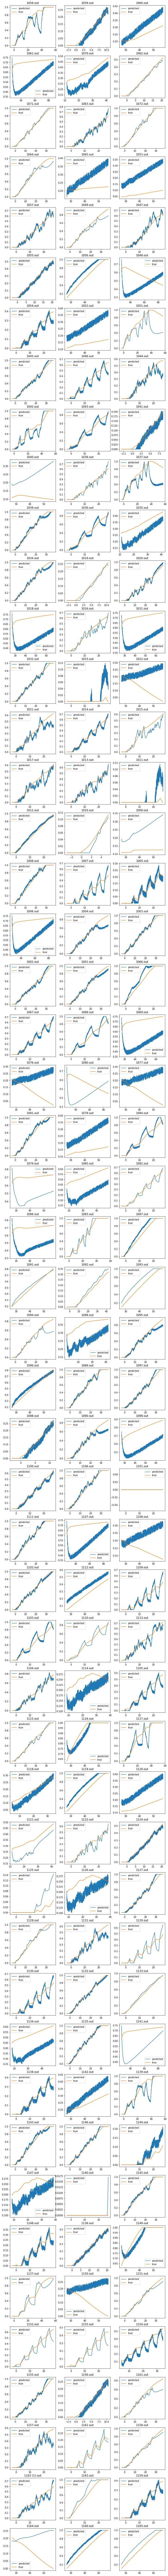

In [131]:
n = len(files)
plt.figure(figsize=(4*3,4*(n//3+1)))
for i in range(n):
    plt.subplot(n//3+1,3,i+1)
    plot(X[i,:,0].reshape(npts),y_p[i,:,:].reshape(npts))
    plot(X[i,:,0].reshape(npts),y[i,:,:].reshape(npts))
    plt.title(files[i])
    plt.legend(['predicted','true']*n)
    


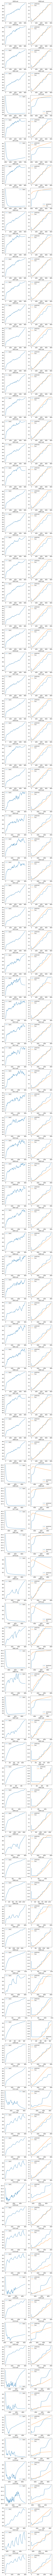

In [ ]:
plt.figure(figsize=(12,4*len(files)))
for i in range(len(files)):
    plt.subplot(len(files),3,3*i+1)
    plot(X[i,:,0].reshape(npts),X[i,:,1].reshape(npts))
    plt.legend(['input'])
    plt.subplot(len(files),3,3*i+2)
    plot(X[i,:,0].reshape(npts),X[i,:,2].reshape(npts))
    plt.legend(['input'])
    plt.title(files[i])
    plt.subplot(len(files),3,3*i+3)
    plot(X[i,:,0].reshape(npts),y_p[i,:,:].reshape(npts))
    plot(X[i,:,0].reshape(npts),y[i,:,:].reshape(npts))
    plt.title(files[i])
    plt.legend(['predicted','true'])